In [54]:
import logging
import os
import json
import time

import h5py
import numpy as np

from annoy import AnnoyIndex
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [55]:
#Load model

In [56]:
def load_features(features_filename, mapping_filename):

    print ("Loading features...")
    images_features = np.load('%s.npy' % features_filename)
    with open('%s.json' % mapping_filename) as f:
        index_str = json.load(f)
        file_index = {int(k): str(v) for k, v in index_str.items()}
    return images_features, file_index

In [57]:
path1 = '/Users/mac/Documents/Machine Learning/Machine Learning Courses/Courses at Vietnam National University/10. Capstone project/Final project/Code'

# path1 = '/Users/mac/Documents/Machine Learning/Machine Learning Courses/Courses at Vietnam National University/Capstone project/Final project/Code'

In [58]:
images_features, file_index = load_features(path1, path1)

Loading features...


In [59]:
def get_class_weights_from_vgg(save_weights=False, filename='class_weights'):

    model_weights_path = os.path.join(os.environ.get('HOME'),
                                      '.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels.h5')
    weights_file = h5py.File(model_weights_path, 'r')
    weights_file.get('predictions').get('predictions_W_1:0')
    final_weights = weights_file.get('predictions').get('predictions_W_1:0')

    class_weights = np.array(final_weights)[:]
    weights_file.close()
    if save_weights:
        np.save('%s.npy' % filename, class_weights)
    return class_weights

In [60]:
def get_weighted_features(class_index, images_features):

    class_weights = get_class_weights_from_vgg()
    target_class_weights = class_weights[:, class_index]
    weighted = images_features * target_class_weights
    return weighted

In [61]:
def index_features(features, n_trees=1000, dims=4096, is_dict=False):

    print ("Indexing features...")
    feature_index = AnnoyIndex(dims, metric='angular')
    for i, row in enumerate(features):
        vec = row
        if is_dict:
            vec = features[row]
        feature_index.add_item(i, vec)
    feature_index.build(n_trees)
    return feature_index

In [62]:
path2 = '/Users/mac/Documents/Machine Learning/Machine Learning Courses/Courses at Vietnam National University/10. Capstone project/Final project/Report'

In [63]:
weighted_features, file_index = load_features(path2, path2)

Loading features...


In [64]:
weighted_index = index_features(weighted_features)

Indexing features...


In [65]:
input_train = '/Users/mac/Documents/Machine Learning/Machine Learning Courses/Courses at Vietnam National University/10. Capstone project/Final project/Data/TrainingData/class-điện thoại/465.jfif'

In [66]:
def get_index(input_image, file_mapping):
    for index, file in file_mapping.items():
        if file == input_image:
            return index
    raise ValueError("Image %s not indexed" % input_image)

In [67]:
search_key = get_index(input_train, file_index)

In [68]:
def search_index_by_key(key, feature_index, item_mapping, top_n=10):

    distances = feature_index.get_nns_by_item(key, top_n, include_distances=True)
    return [[a, item_mapping[a], distances[1][i]] for i, a in enumerate(distances[0])]

In [69]:
weighted_results = search_index_by_key(search_key, weighted_index, file_index)

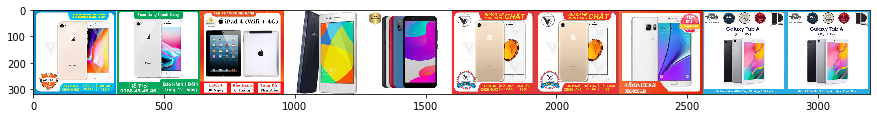

In [70]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for i in range(len(weighted_results)):
    im = weighted_results[i][1]
    img=mpimg.imread(im)
    if i==0:
        img_ = img.copy()
    else:
        img_ = np.concatenate((img_,img), axis=1)

plt.figure(figsize=(15,15))
plt.imshow(img_)
plt.show()

In [71]:
#Testing

In [72]:
import os
import numpy as np
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing import image


def load_paired_img_wrd(folder):

    class_names = [fold for fold in os.listdir(folder) if ".DS" not in fold]
    image_list = []
    labels_list = []
    paths_list = []
    for cl in class_names:
        splits = cl.split("_")
        
        subfiles = [f for f in os.listdir(folder + "/" + cl) if ".DS" not in f]

        for subf in subfiles:
            full_path = os.path.join(folder, cl, subf)
            img = image.load_img(full_path, target_size=(224, 224))
            x_raw = image.img_to_array(img)
            x_expand = np.expand_dims(x_raw, axis=0)
            x = preprocess_input(x_expand)
            image_list.append(x)
            paths_list.append(full_path)
    img_data = np.array(image_list)
    img_data = np.rollaxis(img_data, 1, 0)
    img_data = img_data[0]

    return img_data, paths_list

In [73]:
val_path = '/Users/mac/Documents/Machine Learning/Machine Learning Courses/Courses at Vietnam National University/10. Capstone project/Final project/Data/ValidationData'

In [74]:
img, img_paths = load_paired_img_wrd(val_path)

In [75]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model

def load_headless_pretrained_model():

    pretrained_vgg16 = vgg16.VGG16(weights='imagenet', include_top=True)
    model = Model(inputs=pretrained_vgg16.input,
                  outputs=pretrained_vgg16.get_layer('fc2').output)
    return model

In [76]:
model = load_headless_pretrained_model()

In [77]:
def generate_features(image_paths, model):

    print ("Generating features...")
    start = time.time()
    images = np.zeros(shape=(len(image_paths), 224, 224, 3))
    file_mapping = {i: f for i, f in enumerate(image_paths)}

    # We load all our dataset in memory because it is relatively small
    for i, f in enumerate(image_paths):
        img = image.load_img(f, target_size=(224, 224))
        x_raw = image.img_to_array(img)
        x_expand = np.expand_dims(x_raw, axis=0)
        images[i, :, :, :] = x_expand

    logger.info("%s images loaded" % len(images))
    inputs = preprocess_input(images)
    logger.info("Images preprocessed")
    images_features = model.predict(inputs)
    end = time.time()
    logger.info("Inference done, %s Generation time" % (end - start))
    return images_features, file_mapping

In [78]:
img_features, file_index1 = generate_features(img_paths, model)

Generating features...


In [79]:
a = []
for i in range(len(file_index),len(file_index)+len(file_index1)+1):
    a.append(i)

In [80]:
b = file_index1.values()

In [81]:
dictionary = dict(zip(a,b))

In [82]:
file_index.update(dictionary)

In [83]:
weighted_features1 = get_weighted_features(284, img_features)

weighted_index1 = index_features(weighted_features1)

Indexing features...


In [84]:
vec1 = []

for i in range(len(dictionary)):
    x = weighted_index1.get_item_vector(i)
    vec1.append(x)

In [85]:
for i in range(len(file_index)-len(file_index1),len(file_index)):
    weighted_index.add_item(i,vec1[i-(len(file_index)-len(file_index1))])

In [86]:
input_path = '/Users/mac/Documents/Machine Learning/Machine Learning Courses/Courses at Vietnam National University/10. Capstone project/Final project/Data/ValidationData/images/vali808.jpg'

In [87]:
search_key1 = get_index(input_path, file_index)

In [88]:
results = search_index_by_key(search_key1, weighted_index, file_index)

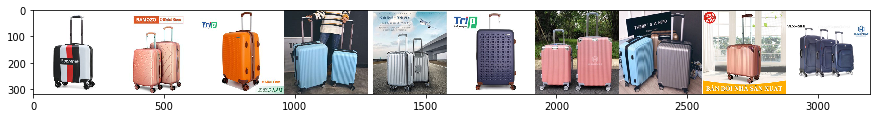

In [89]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for i in range(len(results)):
    im = results[i][1]
    img=mpimg.imread(im)
    if i==0:
        img_ = img.copy()
    else:
        img_ = np.concatenate((img_,img), axis=1)

plt.figure(figsize=(15,15))
plt.imshow(img_)
plt.show()